Мне ещё кое-что нужно - аннотация позиций генов.

Задачу нужно делать по выравниванию и для каждой последовательности индивидуально. Мне не важна позиция каждого нуклеотида в последовательности, важна позиция в кодоне. 
В итоге, для каждой веточки пробегается по кодонам, которые были изменены (нужна фиктивная колонка с индексами, чтобы легко выделять позицию в кодоне), собираем информацию о том, что это за мутация (0,1,2 это все, син и фф соотв., так будет легко фильтровать),пишем все в табличку. Отдельно нужно сохранять частоты триплетов и нуклеотидов для каждой родительской ноды.

In [1]:
from queue import Queue
from typing import Iterable
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ete3
from ete3 import PhyloTree
from scipy.stats import entropy

from Bio.Data import CodonTable

In [103]:
path_to_tree = "../data/interim/iqtree_runs/drun1/anc.treefile"
path_to_states = "../data/interim/iqtree_runs/drun1/anc.state"
path_to_leaves = "../data/interim/leaves_states.tsv"

In [3]:
tree = tree = PhyloTree(path_to_tree, format=1)

In [4]:
tree.describe()

Number of leaf nodes:	144
Total number of nodes:	286
Rooted:	No
Most distant node:	Meloidogyne_javanica
Max. distance:	5.446504


In [4]:
# print(tree.get_ascii())
tree.show()

In [105]:
anc = pd.read_csv(path_to_states, sep="\t", comment='#',)
print(anc.shape)

leaves = pd.read_csv(path_to_leaves, sep="\t")
print(leaves.shape)

pd.concat([anc.head(), leaves.head()])

(1423266, 8)
(1432827, 8)


,Node,Part,Site,State,p_A,p_C,p_G,p_T
0,Node6,1,1,T,0.03012,0.00375,0.00625,0.95988
1,Node6,1,2,T,0.00001,0.00006,0.00000,0.99993
2,Node6,1,3,G,0.30508,0.02994,0.53229,0.13270
3,Node6,1,4,T,0.00953,0.30213,0.02986,0.65848
4,Node6,1,5,A,0.54912,0.00212,0.40747,0.04130
0,Philometroides_sanguineus,1,1,T,0.00000,0.00000,0.00000,1.00000
1,Philometroides_sanguineus,1,2,T,0.00000,0.00000,0.00000,1.00000
2,Philometroides_sanguineus,1,3,G,0.00000,0.00000,1.00000,0.00000
3,Philometroides_sanguineus,1,4,A,1.00000,0.00000,0.00000,0.00000
4,Philometroides_sanguineus,1,5,T,0.00000,0.00000,0.00000,1.00000


In [112]:
leaves.Node.unique()[:5]

array(['Philometroides_sanguineus', 'Dracunculus_medinensis',
       'Wellcomia_siamensis', 'Spirocerca_lupi', 'Gnathostoma_spinigerum'],
      dtype=object)

In [116]:
leaves[leaves.Node == "Philometroides_sanguineus"].Part.value_counts()

5    2712
2    2223
3    1977
4    1923
1     960
Name: Part, dtype: int64

In [124]:
aln_sizes = leaves.groupby("Node").apply(len)
aln_sizes[aln_sizes != 10023]

Node
Baylisascaris_transfuga                         9258
Cylicodontophorus_bicoronatus                   8484
Cylicostephanus_minutus                         8484
Heliconema_longissimum                          9165
Mecistocirrus_digitatus                         9606
Philometroides_sanguineus                       9795
Pseudoterranova_azarasi                         7746
Pseudoterranova_decipiens_sensu_lato_Germany    8454
Setaria_digitata                                9699
Spirocerca_lupi                                 9606
Thelazia_callipaeda                             9471
dtype: int64

In [125]:
uncomplete_nodes = aln_sizes[aln_sizes != 10023].index.values
uncomplete_nodes

array(['Baylisascaris_transfuga', 'Cylicodontophorus_bicoronatus',
       'Cylicostephanus_minutus', 'Heliconema_longissimum',
       'Mecistocirrus_digitatus', 'Philometroides_sanguineus',
       'Pseudoterranova_azarasi',
       'Pseudoterranova_decipiens_sensu_lato_Germany', 'Setaria_digitata',
       'Spirocerca_lupi', 'Thelazia_callipaeda'], dtype=object)

In [141]:
some_node = uncomplete_nodes[0]
while some_node in uncomplete_nodes:
    some_node = leaves.Node.sample().values[0]
some_node

'Haemonchus_placei'

In [ ]:
un = uncomplete_nodes[0]

set(map(tuple, leaves[leaves.Node == un][["Part", "Site"]].values))

In [121]:
anc.groupby("Node").apply(len).value_counts()

10023    142
dtype: int64

In [115]:
leaves[leaves.Node == "Dracunculus_medinensis"].Part.value_counts()

5    2940
2    2223
3    1977
4    1923
1     960
Name: Part, dtype: int64

In [8]:
anc[anc.Node == "Node6"].Part.value_counts()

5    2940
2    2223
3    1977
4    1923
1     960
Name: Part, dtype: int64

In [9]:
anc[anc.Node == "Node6"]

,Node,Part,Site,State,p_A,p_C,p_G,p_T
0,Node6,1,1,T,0.03012,0.00375,0.00625,0.95988
1,Node6,1,2,T,0.00001,0.00006,0.00000,0.99993
2,Node6,1,3,G,0.30508,0.02994,0.53229,0.13270
3,Node6,1,4,T,0.00953,0.30213,0.02986,0.65848
4,Node6,1,5,A,0.54912,0.00212,0.40747,0.04130
...,...,...,...,...,...,...,...,...
10018,Node6,5,2936,T,0.00041,0.00338,0.00014,0.99606
10019,Node6,5,2937,T,0.11066,0.06397,0.06969,0.75568
10020,Node6,5,2938,T,0.09209,0.06654,0.06031,0.78106
10021,Node6,5,2939,T,0.00006,0.00063,0.00002,0.99929


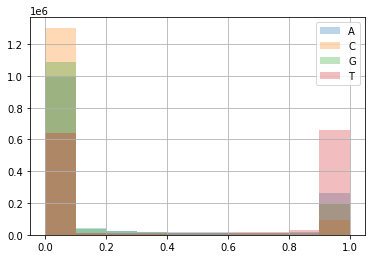

In [10]:
anc.p_A.hist(alpha=.3, label="A")
anc.p_C.hist(alpha=.3, label="C")
anc.p_G.hist(alpha=.3, label="G")
anc.p_T.hist(alpha=.3, label="T")
plt.legend()

## 10% of positions are uncertain

In [11]:
np.any(anc[["p_A", "p_C", "p_G", "p_T"]] > 0.8, 1).value_counts(normalize=True)

True     0.894154
False    0.105846
dtype: float64

In [13]:
mentr = anc[["p_A", "p_C", "p_G", "p_T"]].apply(entropy, 1)

Text(0.5, 1.0, 'Entropy')

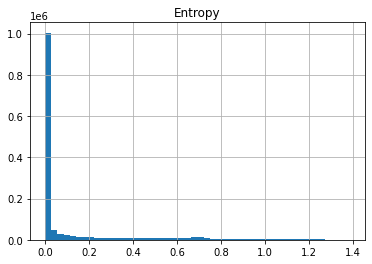

In [14]:
mentr.hist(bins=50)
plt.title("Entropy")

<AxesSubplot:>

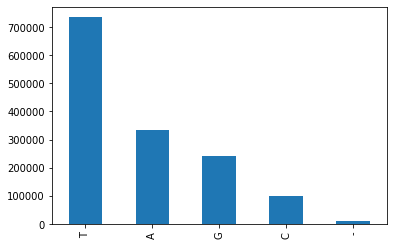

In [15]:
anc.State.value_counts().plot.bar()

In [16]:
anc2 = anc.sort_values(["Node", "Part", "Site"])
anc2.head()

,Node,Part,Site,State,p_A,p_C,p_G,p_T
1413243,Node1,1,1,A,0.56753,0.00222,0.02273,0.40751
1413244,Node1,1,2,T,0.00001,0.00003,0.00000,0.99996
1413245,Node1,1,3,T,0.17456,0.05253,0.16762,0.60528
1413246,Node1,1,4,T,0.10452,0.01489,0.07249,0.80810
1413247,Node1,1,5,T,0.00014,0.00067,0.00007,0.99912


In [17]:
def extract_ff_codons(codontable):
    aa2codons = defaultdict(set)
    for codon, aa in codontable.forward_table.items():
        aa2codons[aa].add(codon)

    ff_codons = set()
    for aa, codons in aa2codons.items():
        if len(codons) >= 4:
            interim_dct = defaultdict(set)
            for codon in codons:
                interim_dct[codon[:2]].add(codon)
            
            for nn in interim_dct:
                if len(interim_dct[nn]) == 4:
                    ff_codons = ff_codons.union(interim_dct[nn])
    return ff_codons


codontable = CodonTable.unambiguous_dna_by_id[5]
ff_codons = extract_ff_codons(codontable)


def node_parent(node):
    try:
        return next(node.iter_ancestors())
    except BaseException:
        return None


def get_mut_label(codon1: str, codon2: str):
    """
    returned labels:
    - -1 - error mutation (contains stopcodon)
    -  0 - usual mutation
    -  1 - synonimous mutation
    """
    aa1 = codontable.forward_table.get(codon1, "*")
    aa2 = codontable.forward_table.get(codon2, "*")
    if aa1 == "*" or aa2 == "*":
        label = -1
    elif aa1 == aa2:
        label = 1
    else:
        label = 0
    
    return label, aa1, aa2


def is_four_fold(codon):
    return codon in ff_codons


def extract_mutations(g1: Iterable, g2: Iterable, nodename1: str, nodename2: str, context=False):
    """
    TODO: work only with changed positions, not all
    table -> indexes of mutated -> extended indexes with codons 
    
    params:
    - g1 - reference genome (parent node)
    - g2 - alternative genome (child node)
    """
    n, m = len(g1), len(g2)
    assert n == m, (
        f"genomes lengths are not equal: {n} != {m}"
    )
    assert n % 3 == 0, "genomes length must be divisible by 3"

    mutations = []
    for i in range(0, n - 2, 3):
        codon1 = g1[i: i + 3]
        codon2 = g2[i: i + 3]
        if (codon1 == codon2).sum() != 2 or '-' in codon1 or '-' in codon2:
            continue
        
        codon1_str = "".join(codon1)
        codon2_str = "".join(codon2)
        
        label, aa1, aa2 = get_mut_label(codon1_str, codon2_str)

        for j in range(3):
            nuc1, nuc2 = codon1[j], codon2[j]
            if nuc1 == nuc2:
                continue
            if label == 1 and j == 2:
                label = 2 if is_four_fold(codon1_str) else label
            
            sbs = {
                "RefNode": nodename1,
                "AltNode": nodename2,
                "Mut": f"{nuc1}>{nuc2}",
                "RefNucl": nuc1,
                "AltNucl": nuc2,
                "Label": label,
                "Pos": i + j + 1,
                "PosInCodon": j + 1,
                "RefCodon": codon1_str,
                "AltCodon": codon2_str,
            }
            mutations.append(sbs)
    return mutations

In [89]:
node2genome = dict()
gr = anc2.groupby("Node")
for node in anc2.Node.unique():
    node2genome[node] = gr.get_group(node).State

In [92]:
possible_sbs = {
    'A>C', 'A>G', 'A>T', 
    'C>A', 'C>G', 'C>T', 
    'G>A', 'G>C', 'G>T', 
    'T>A', 'T>C', 'T>G'
}
nodes = set(anc.Node)
discovered_nodes = set()
Q = Queue()
Q.put(tree)
discovered_nodes.add(tree.name)
    
edge_mutspec = []
mutations = []
while not Q.empty():
    cur_node = Q.get()
    for child in cur_node.children:
        Q.put(child)

    if cur_node.name not in discovered_nodes:
        discovered_nodes.add(cur_node.name)

        if cur_node.name not in nodes:
            continue

        # main process starts here
        parent_node = node_parent(cur_node)

        # BOTTLENECK - TODO reblace by dct
        ##############################
        # parent_genome = anc2[anc2.Node == parent_node.name].State
        # child_genome = anc2[anc2.Node == cur_node.name].State
        ###############################
        parent_genome = node2genome[parent_node.name]
        child_genome = node2genome[cur_node.name]

        _mut_lst = extract_mutations(
            parent_genome.values, 
            child_genome.values,
            parent_node.name,
            cur_node.name,
        )
        mut = pd.DataFrame(_mut_lst)
        mutations.append(mut)
        
        nucl_freqs = parent_genome.value_counts().to_dict()
        
        mutspec = mut[mut.Label > 0].Mut.value_counts().reset_index()
        mutspec.columns = ["Mut", "ObsFr"]

        nd = []
        for unobserved_sbs in possible_sbs.difference(mutspec.Mut.values):
            nd.append({"Mut": unobserved_sbs, "ObsFr": 0})
        mutspec = pd.concat([mutspec, pd.DataFrame(nd)], ignore_index=True)

        mutspec["RefNuc"] = mutspec.Mut.str.get(0)
        mutspec["AltNuc"] = mutspec.Mut.str.get(2)
        mutspec["Divisor"] = mutspec.RefNuc.map(nucl_freqs)
        mutspec["RawMutSpec"] = mutspec.ObsFr / mutspec.Divisor
        mutspec["MutSpec"] = mutspec["RawMutSpec"] / mutspec["RawMutSpec"].sum()
        mutspec["RefNode"] = parent_node.name
        mutspec["AltNode"] = cur_node.name

        edge_mutspec.append(mutspec)
        # break

mutations = pd.concat(mutations)
edge_mutspec = pd.concat(edge_mutspec)

In [93]:
edge_mutspec

,Mut,ObsFr,RefNuc,AltNuc,Divisor,RawMutSpec,MutSpec,RefNode,AltNode
0,G>A,104,G,A,1678,0.061979,0.735523,Node1,Node2
1,A>G,20,A,G,1953,0.010241,0.121530,Node1,Node2
2,A>T,8,A,T,1953,0.004096,0.048612,Node1,Node2
3,T>A,4,T,A,5361,0.000746,0.008855,Node1,Node2
4,G>T,3,G,T,1678,0.001788,0.021217,Node1,Node2
...,...,...,...,...,...,...,...,...,...
7,G>C,2,G,C,1743,0.001147,0.021212,Node93,Node94
8,T>G,2,T,G,4723,0.000423,0.007828,Node93,Node94
9,C>G,1,C,G,755,0.001325,0.024485,Node93,Node94
10,A>C,0,A,C,2792,0.000000,0.000000,Node93,Node94


In [51]:
mutations

,RefNode,AltNode,Mut,RefNucl,AltNucl,Label,Pos,PosInCodon,RefCodon,AltCodon
0,Node1,Node2,G>T,G,T,0,30,3,TTG,TTT
1,Node1,Node2,A>G,A,G,0,100,1,ATT,GTT
2,Node1,Node2,G>A,G,A,0,112,1,GAT,AAT
3,Node1,Node2,G>A,G,A,0,118,1,GAT,AAT
4,Node1,Node2,A>T,A,T,0,122,2,AAA,ATA
...,...,...,...,...,...,...,...,...,...,...
129,Node93,Node94,A>G,A,G,1,8514,3,ATA,ATG
130,Node93,Node94,A>G,A,G,1,8757,3,TGA,TGG
131,Node93,Node94,A>G,A,G,2,8775,3,TCA,TCG
132,Node93,Node94,G>A,G,A,2,8883,3,AGG,AGA


In [95]:
common_mutspec = edge_mutspec.groupby("Mut")[["ObsFr", "RawMutSpec"]].sum()
common_mutspec["MutSpec"] = common_mutspec["RawMutSpec"] / common_mutspec["RawMutSpec"].sum()
common_mutspec

,ObsFr,RawMutSpec,MutSpec
Mut,,,
A>C,36,0.014276,0.001658
A>G,6269,2.728212,0.316777
A>T,1530,0.608403,0.070643
C>A,27,0.037746,0.004383
C>G,53,0.071586,0.008312
C>T,732,0.957162,0.111137
G>A,4868,2.849362,0.330844
G>C,61,0.031075,0.003608
G>T,436,0.220739,0.025630


<AxesSubplot:xlabel='Mut'>

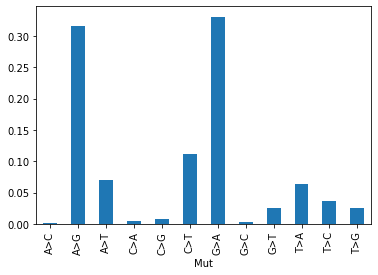

In [96]:
common_mutspec.MutSpec.plot.bar()

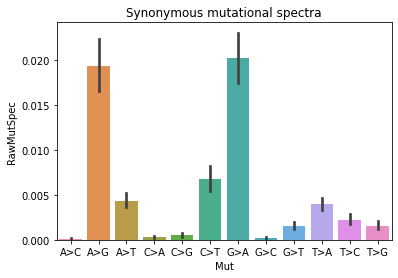

In [102]:
sns.barplot(x="Mut", y="RawMutSpec", data=edge_mutspec, order=sorted(edge_mutspec.Mut.unique()));
plt.title("Synonymous mutational spectra");

In [98]:
pref_sbs = "C>T"
edge_mutspec[edge_mutspec.Mut == pref_sbs][["RefNode", "AltNode", "MutSpec"]].to_csv("../data/interim/c2t_edge_mutspec.tsv", "\t", index=None)

<AxesSubplot:>

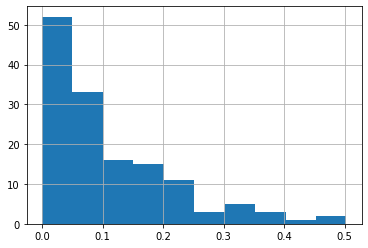

In [99]:
edge_mutspec[edge_mutspec.Mut == pref_sbs]["MutSpec"].hist()

In [101]:
edge_mutspec.to_csv("../data/interim/mutspec_nematoda.csv", index=None)